In [40]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### 개요

넷플릭스 데이터를 기반으로 한 비즈니스 분석

### 분석 목표

<span style = "font-size:18px">
1. Understanding what content is available in different countries <br>
2. Identifying similar content by matching text-based features <br>
3. Network analysis of Actors / Directors and find interesting insights <br>
4. Does Netflix has more focus on TV Shows than movies in recent years <br> 
</span>

### 분석 과정

- 국가별 컨텐츠 제작 특징
1. 컨텐츠를 100개 이상 제작한 국가로 분석을 한정
2. 성인연령 등급 vs 전연령 등급 두 가지로 분류하여 제작 비율 분석
3. 컨텐츠의 장르 (다큐멘터리, 범죄, 애니메이션 등) 비율 분석

- 비슷한 내용의 컨텐츠 페어 찾기
1. SentenceTransformer의 Bert 모델을 활용, Description의 데이터를 기반으로 비슷한 내용의 컨텐츠 페어를 찾음. 단, 시리즈물은 제외


- 넷플릭스의 영화/TV 프로그램 월별 등록 비율 분석
1. 2008년부터 2021년까지 월별 영화/TV프로그램 등록 비율 그래프 시각화
2. 차이를 Moving Average (window = 5)로 시각화


- 미국영화계의 소셜네트워크 분석
1. 4번 이상 함께한 감독 - 배우간의 조합 분석
2. 4번 이상 함께한 배우 - 배우간의 조합 분석
3. 최단경로 분석 실시에서 3번 이상 출연한 배우+감독들을 바탕으로 소셜 네트워크 분석



### 분석 결과 요약

- 국가별 컨텐츠 제작 특징

1. 멕시코의 성인연령 등급 제작 비율이 높고 인도, 이집트 등의 성인연령 등급 제작 비율이 낮았다.

2. 터키, 이집트, 인도의 경우 비교적 전연령 등급을 많이 제작하는 편이었다. 이러한 국가들은 주로 코미디 장르를 많이 제작한다. 반면 한일의 경우 상당히 적은 편

3. 모든 국가에서 코미디 시리즈의 비율이 평균적으로 많다. 다만 홍콩은 액션&어드벤처가, 일본은 애니메이션이 비교적 많다

4. 멕시코, 스페인의 경우 범죄 관련 드라마가 많을 것으로 예상했으나 실제로는 4~7%밖에 되지 않는다

- 비슷한 내용의 컨텐츠 페어 찾기

1. 유사도가 0.7 이상인 페어는 61쌍, 0.6 이상인 페어는 대략 1800쌍 정도 된다.


- 넷플릭스의 영화/TV 프로그램 월별 등록 비율 분석

1. 영화와 TV프로그램 등록 수에 있어서 2016년까지는 큰 차이가 없었으나, 이후 2018년 하반기까지 그래프가 서서히 우상향을 그리고 있는 것을 알 수 있다. 이후 2019~2021년까지 차이는 매달 50~75개로 유지되고 있다.

2. 코로나가 터지기 직전인 2019년 10월부터 2020년 4월까지 갑작스럽게 영화 등록이 늘어난 것을 알 수 있는데, 그 이유에 대해선 이는 추가적인 조사가 필요할 것이다


- 미국영화계의 소셜네트워크 분석

1. 코미디 장르에서 두각을 나타내는 조합인 Michael Tiddes - Marlon Wayans 감독 - 배우 조합, 범죄/인간 심리와 같은 장르에서 두각을 나타내는 조합인 Martin Scorsese - Robert De Niro 등을 확인


2. 미국 영화계에서 3번 이상 영화/TV프로그램에 출연한 디렉터/배우들 1876명 중, 6명을 제외한
1870명은 모두 평균 2.5 다리를 건너면 아는 사이이다. 


### 인사이트 추출

1. 컨텐츠간의 유사도를 바탕으로 사용자의 시청기록을 분석, 비슷한 영화/드라마 추천시스템에 활용할 수 있다.
2. 다만, 처음엔 유사도를 0.6 이상인 컨텐츠 페어들을 기반으로 추천 시스템을 도입 후, 시청자들이 비슷한 내용의 영화/드라마들을 추가로 시청하지 않는다면 기준 유사도를 올려가며 시청자들이 추천 시스템의 영화/TV프로그램들을 끝까지 시청하는지 분석해야할 것이다
3. 시청자가 해당 감독과 배우가 출연한 영화/TV프로그램을 시청하였을 경우, 추천 시스템에서 해당 감독/배우의 조합이 나오는 다른 영화를 추천시스템에 넣을 수 있다. 비슷한 스타일, 배우가 출연하기에 시청자가 선호할 가능성이 존재한다


In [41]:
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."


In [42]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


첫번째 목표: 각 국가별로 주로 어떤 장르와 연령등급의 영상물을 제작하는가

In [43]:
country = df.copy()
country.drop(columns = ['show_id'], inplace = True)
country.dropna(subset = ['country'], inplace = True)
rating_unique = country['rating'].unique()
print(rating_unique)

['PG-13' 'TV-MA' 'TV-14' 'TV-Y7' 'PG' 'R' 'TV-PG' 'TV-Y' 'TV-G' 'G'
 'NC-17' '74 min' '84 min' '66 min' 'NR' 'TV-Y7-FV' nan 'UR']


영화 등급 (영화 협회 등급, MPAA)
G (General Audience)
모든 연령이 관람 가능. 폭력, 성적 콘텐츠, 욕설 등이 전혀 포함되지 않은 콘텐츠.

PG (Parental Guidance Suggested)
일부 장면에서 부모의 지도가 필요할 수 있음. 어린이에게 적합하지 않을 수도 있는 경미한 폭력이나 언급이 포함될 수 있음.

PG-13 (Parents Strongly Cautioned)
13세 미만은 부모의 강력한 지도 필요. 심한 욕설, 성적 콘텐츠, 폭력 등이 제한적으로 포함될 수 있음.

R (Restricted)
17세 미만은 부모 또는 성인 보호자 동반 필요. 폭력적이거나 성적이거나 언어적으로 강한 콘텐츠 포함 가능.

NC-17 (Adults Only)
17세 미만 관람 불가. 성적 콘텐츠나 폭력 등이 매우 강하고, 일반 극장 상영용으로 적합하지 않음.

NR (Not Rated)
등급이 공식적으로 지정되지 않은 콘텐츠.

UR (Unrated)
검열되지 않거나 심사를 거치지 않은 콘텐츠.

---

TV 등급 (TV Parental Guidelines)
TV-Y (All Children)
어린이에게 적합. 교육적이고 폭력이나 성적 콘텐츠가 전혀 없는 프로그램.

TV-Y7 (Directed to Older Children)
7세 이상 어린이를 대상으로 함. 경미한 폭력이나 상상 속의 위험 요소를 포함할 수 있음.

TV-Y7-FV (Fantasy Violence)
상상 속 폭력(Fantasy Violence)을 강조한 TV-Y7 등급.

TV-G (General Audience)
모든 연령이 시청 가능. G 등급과 유사하게 가족 모두에게 적합.

TV-PG (Parental Guidance Suggested)
부모의 지도가 필요할 수 있는 TV 콘텐츠. 약간의 폭력이나 언급이 포함될 수 있음.

TV-14 (Parents Strongly Cautioned)
14세 미만 시청자가 부모의 강력한 지도 필요. 성적 콘텐츠, 폭력, 언어가 포함될 가능성이 있음.

TV-MA (Mature Audiences Only)
성인 전용. 17세 이상만 시청 권장. 성적 콘텐츠, 욕설, 폭력 등이 포함됨.

In [44]:
country = country[~country['rating'].isin(['74 min' '84 min' '66 min'])]
country.dropna(subset = ['rating'], inplace = True)
country.reset_index(drop = True, inplace = True)
country_df = country.copy()
country_df['country'] = country_df['country'].str.split(', ')
country_df = country_df.explode('country').reset_index(drop = True)
country_df = country_df[country_df['country'].map(
                country_df.groupby('country').size() ) >= 100
]

country_df.reset_index(drop = True, inplace = True)
country_rating = country_df.groupby(['country', 'rating']).size()
country_rating_prop = country_rating / country_rating.groupby(level = 'country').sum()
country_rating_prop = country_rating_prop.round(2)
country_rating_prop_df = country_rating_prop.reset_index(name = 'prop')

rating_group_map = {'R': 'Adult', 'NC-17': 'Adult', 'TV-MA': 'Adult', 'G': 'Family',
    'PG': 'Family','PG-13': 'Family', 'TV': 'Family','TV-Y7': 'Family', 'TV-Y7-FV': 'Family',
    'TV-G': 'Family','TV-PG': 'Family','TV-14': 'Family','NR': 'Unrated','UR': 'Unrated'}

country_rating_prop_df['rating'] = country_rating_prop_df['rating'].map(rating_group_map)
grouped_rating_prop = country_rating_prop_df.groupby(['country', 'rating'])['prop'].sum().reset_index()
grouped_rating_adult = grouped_rating_prop[grouped_rating_prop['rating'] == 'Adult' ]
grouped_rating_adult.sort_values('prop', ascending = True, inplace = True)
grouped_rating_adult

<ipython-input-44-093c7ee5ae8c>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_rating_adult.sort_values('prop', ascending = True, inplace = True)


,country,rating,prop
20,India,Adult,0.25
9,Egypt,Adult,0.28
6,China,Adult,0.33
23,Japan,Adult,0.35
0,Australia,Adult,0.41
31,South Korea,Adult,0.41
3,Canada,Adult,0.42
28,Nigeria,Adult,0.43
43,United States,Adult,0.48
17,Hong Kong,Adult,0.49


해당 데이터를 보면 스페인, 멕시코의 성인연령 등급 제작 비율이 높고, <br>
인도, 이집트 등의 성인연령 등급 제작 비율이 낮음을 알 수 있다. <br>
우선, 해당 7개의 국가들이 주로 어떤 장르를 제작하는지 알아보자

In [45]:
country['country'] = country['country'].str.split(', ')
country = country.explode('country').reset_index(drop = True)
country = country[country['country'].map(
    country.groupby(['country']).size()) >= 100 ]
country.reset_index(drop = True, inplace = True)

country_df = country.copy()
country_df['listed_in'] = country_df['listed_in'].str.split(', ')
country_df = country_df.explode('listed_in').reset_index(drop = True)
grouped_genres = country_df.groupby(['country', 'listed_in']).size()
props = grouped_genres / grouped_genres.groupby(level = 'country').sum()
props = props.reset_index(name = 'prop')
filtered_props = props[props['country'].isin(['Spain', 'India', 'Mexico', 'Egypt'])]
filtered_props = filtered_props[filtered_props['prop'] > 0.1]
filtered_props

,country,listed_in,prop
107,Egypt,Comedies,0.192568
110,Egypt,Dramas,0.148649
113,Egypt,International Movies,0.334459
216,India,Comedies,0.115193
221,India,Dramas,0.236091
225,India,International Movies,0.308131
290,Mexico,Dramas,0.107579
294,Mexico,International Movies,0.171149
295,Mexico,International TV Shows,0.105134
304,Mexico,Spanish-Language TV Shows,0.114914


listed_in 데이터로 보았을 때, 이집트와 인도는 코미디물을 비교적 많이 제작한다는 것을 알 수 있다. 그렇다면 다른 국가들과 비교해서도 그럴까? 

In [46]:
comedy_props = props[props['listed_in'] == 'Comedies' ]
comedy_props_sorted = comedy_props.sort_values('prop', ascending = False)
comedy_props_sorted

,country,listed_in,prop
392,Turkey,Comedies,0.194631
107,Egypt,Comedies,0.192568
314,Nigeria,Comedies,0.153558
195,Hong Kong,Comedies,0.125954
216,India,Comedies,0.115193
41,Canada,Comedies,0.107184
455,United States,Comedies,0.100310
163,Germany,Comedies,0.082192
78,China,Comedies,0.079897
363,Spain,Comedies,0.079526


터키, 이집트, 인도의 경우 비교적 전연령 등급을 많이 제작하는 편이었다. 이러한 국가들은 주로 코미디 장르를 많이 제작한다는 것을 알 수 있다. 반면 한일의 경우 상당히 적은 편

In [47]:
heavy_props = props[props['prop'] > 0.1]
heavy_props = heavy_props[~heavy_props['listed_in'].isin(['Dramas', 'International Movies', 'International TV Shows'])] 
heavy_props

,country,listed_in,prop
41,Canada,Comedies,0.107184
73,China,Action & Adventure,0.162371
107,Egypt,Comedies,0.192568
192,Hong Kong,Action & Adventure,0.251908
195,Hong Kong,Comedies,0.125954
216,India,Comedies,0.115193
249,Japan,Anime Series,0.194254
304,Mexico,Spanish-Language TV Shows,0.114914
314,Nigeria,Comedies,0.153558
341,South Korea,Korean TV Shows,0.208861


전체적으로 봐도 코미디 시리즈가 많은 편. 다만 홍콩은 액션&어드벤처가, 일본은 애니메이션이 비교적 많다

멕시코, 스페인의 경우 범죄 관련 드라마가 많을 것으로 예상했으나 실제로는 4~7%밖에 되지 않는다

두 번째 목표:
비슷한 내용의 컨텐츠들끼리 묶기. Description, Listed_in, rating 데이터를 기반으로 한다


In [48]:
pd.set_option('display.max_colwidth', None)
df.drop_duplicates(subset = ['description'], inplace = True)
df[['description']]

,description
0,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
1,"After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,"To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,"Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,"In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."
...,...
8802,"A political cartoonist, a crime reporter and a pair of cops investigate San Francisco's infamous Zodiac Killer in this thriller based on a true story."
8803,"While living alone in a spooky town, a young girl befriends a motley crew of zombie children with diverse personalities."
8804,"Looking to survive in a world taken over by zombies, a dorky college student teams with an urban roughneck and a pair of grifter sisters."
8805,"Dragged from civilian life, a former superhero must train a new crop of youthful saviors when the military preps for an attack by a familiar villain."


In [49]:

model = SentenceTransformer('all-MiniLM-L6-v2')
description_list = df['description'].to_list()
embeddings = model.encode(description_list, convert_to_tensor = True)
similarities = util.pytorch_cos_sim(embeddings, embeddings)
print(similarities)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/275 [00:00<?, ?it/s]

tensor([[1.0000, 0.1937, 0.0732,  ..., 0.2222, 0.2088, 0.1809],
        [0.1937, 1.0000, 0.0126,  ..., 0.2947, 0.1171, 0.0776],
        [0.0732, 0.0126, 1.0000,  ..., 0.1468, 0.3781, 0.3016],
        ...,
        [0.2222, 0.2947, 0.1468,  ..., 1.0000, 0.2949, 0.2461],
        [0.2088, 0.1171, 0.3781,  ..., 0.2949, 1.0000, 0.2236],
        [0.1809, 0.0776, 0.3016,  ..., 0.2461, 0.2236, 1.0000]])


In [50]:
import torch

pairs = []
scores = []

for i in range(similarities.size(0)):
    for j in range(i+1, similarities.size(1)):
        pairs.append( (i,j) )
        scores.append(similarities[i,j].item())

sorted_pairs = sorted(zip(scores, pairs), key = lambda x: x[0], reverse = True)


In [51]:
df.head(1)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."


In [52]:
def has_common_words(title1, title2):
    words1 = set(title1.lower().split())
    words2 = set(title2.lower().split())

    return len(words1 & words2) < 1
def other_commonalities(i, j):
    return (
        (df['rating'].iloc[i] == df['rating'].iloc[j]) and
        (df['type'].iloc[i] == df['type'].iloc[j]) and
        (df['director'].iloc[i] == df['director'].iloc[j]) and 
        (df['listed_in'].iloc[i] == df['listed_in'].iloc[j])
           )
    

filtered_pairs = [(score, pair)  for score, pair in sorted_pairs if 0.7 <= score <= 0.8]

filtered_pairs = [
    (score, pair) for score, pair in filtered_pairs
    if has_common_words(df['title'].iloc[pair[0]], df['title'].iloc[pair[1]])
]

filtered_pairs = [
    (score, pair) for score, pair in filtered_pairs
    if not other_commonalities(pair[0], pair[1]) 
]

top_pairs = filtered_pairs[:10]


for score, (i, j) in top_pairs:
    print(f"Sentence {i}: {description_list[i]}, Title : {df['title'].iloc[i]}")
    print(f"Sentence {j}: {description_list[j]}, Title : {df['title'].iloc[j]}")
    print(f"Similarity Score: {score:.4f}")
    print("-" * 50)


Sentence 2724: Returning home to visit their ill grandfather, two estranged brothers must confront their unresolved rivalry while their parents’ marriage frays., Title : Kapoor & Sons
Sentence 6734: Grappling with love and loss in their respective lives, two estranged brothers must confront their traumatic, unresolved past when they cross paths., Title : Fireflies
Similarity Score: 0.7801
--------------------------------------------------
Sentence 3706: Fifteen years after the Second Impact, apathetic teen Shinji joins his father's group NERV to fight the Angels. But the truth may destroy them all., Title : EVANGELION: DEATH (TRUE)²
Sentence 3710: Fifteen years after the Second Impact, Shinji Ikari joins his father's group NERV as one of several teenage mecha pilots fighting the monstrous Angels., Title : Neon Genesis Evangelion
Similarity Score: 0.7793
--------------------------------------------------
Sentence 5772: Comedians Mariusz Kałamaga, Karol Kopiec and Wiolka Walaszczyk deliv

In [126]:

filtered_pairs = [(score, pair)  for score, pair in sorted_pairs if 0.6<= score <= 0.8]

filtered_pairs = [
    (score, pair) for score, pair in filtered_pairs
    if has_common_words(df['title'].iloc[pair[0]], df['title'].iloc[pair[1]])
]

filtered_pairs = [
    (score, pair) for score, pair in filtered_pairs
    if not other_commonalities(pair[0], pair[1]) 
]

print(len(filtered_pairs))


60


<span style = 'font-size:18px'>
1. SentenceTransformer의 Bert 모델을 이용하면 서로 비슷한 내용의 영화, 드라마들을 짝지을 수 있다. 이 중 필터링을 통해 같은 영화, 혹은 시리즈인 영화/드라마들은 제외하면 다른 영화이지만 비슷한 내용의 페어가 짝지어진다. <br>
2. 해당 리스트들은 사용자의 시청기록을 바탕으로 영화/드라마 추천시스템에 활용할 수 있다. <br>
3. 다만, 해당 추천 시스템을 프로토타입으로 도입 후, 시청자들이 비슷한 내용의 영화/드라마들을 추가로 시청하지 않는다면 그 원인에 대해 분석해보고 추천시스템을 업데이트해야할 것이다.

기간별로 넷플릭스는 TV 프로그램과 영화 중 무엇에 더 치중하는 경향이 있을까? 

In [53]:
df_time = df.copy()
df_time['date_added'] = df_time['date_added'].apply(lambda x : x.strip() if isinstance(x, str) else x )
df_time['date_added'] = pd.to_datetime(df_time['date_added'], format = '%B %d, %Y')
df_time['year_month'] = df_time['date_added'].dt.to_period('M')
df_time = df_time.sort_values('year_month')
date_counts =  df_time.groupby(['year_month', 'type']).size().reset_index(name = 'count')

date_counts.head(5)

,year_month,type,count
0,2008-01,Movie,1
1,2008-02,TV Show,1
2,2009-05,Movie,1
3,2009-11,Movie,1
4,2010-11,Movie,1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


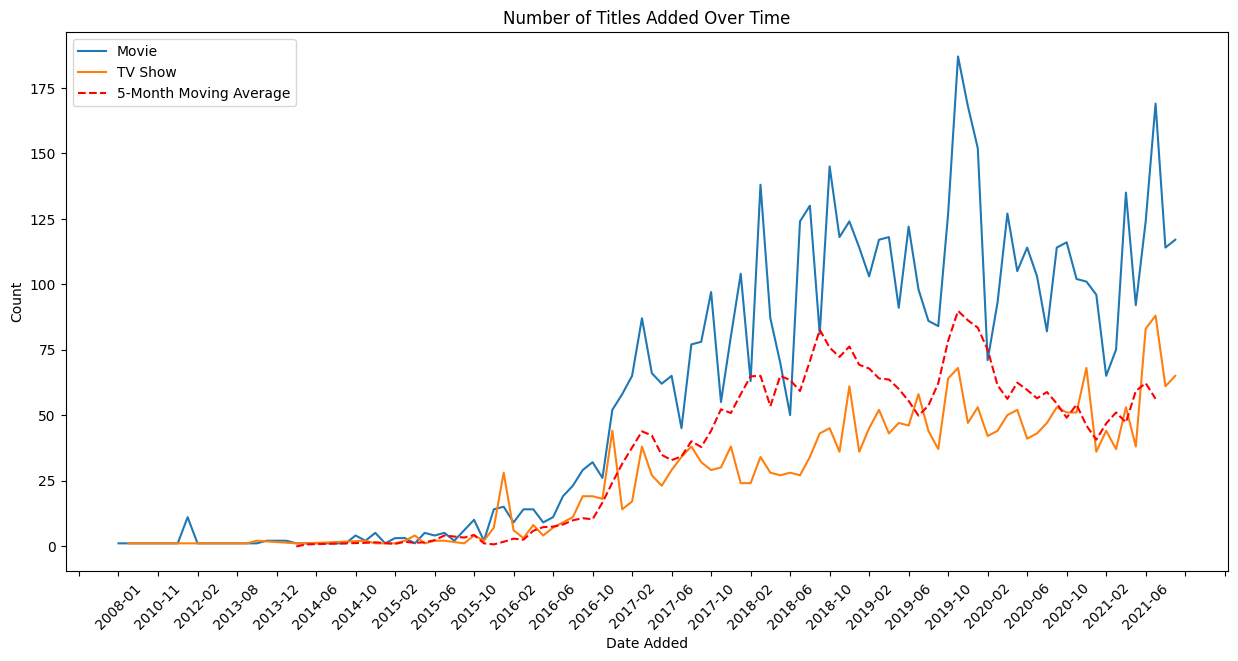

In [65]:
df_time = df.copy()
df_time['date_added'] = df_time['date_added'].apply(lambda x : x.strip() if isinstance(x, str) else x )
df_time['date_added'] = pd.to_datetime(df_time['date_added'], format = '%B %d, %Y')
df_time['year_month'] = df_time['date_added'].dt.to_period('M')
df_time = df_time.sort_values('year_month')
date_counts =  df_time.groupby(['year_month', 'type']).size().reset_index(name = 'count')
date_counts['year_month'] = date_counts['year_month'].astype(str)


movies = date_counts[date_counts['type'] == 'Movie'].copy()
tv_shows = date_counts[date_counts['type'] == 'TV Show'].copy()
diff_data = movies[['year_month', 'count']].merge(
    tv_shows[['year_month', 'count']],
    on = 'year_month',
    how = 'inner',
    suffixes = ('_movies', '_tv_shows')
)
diff_data['difference'] = diff_data['count_movies'] - diff_data['count_tv_shows']
diff_data['ma_difference'] = diff_data['difference'].rolling(window = 5, center=True).mean()


plt.figure(figsize=(15, 7))
sns.lineplot(data=date_counts, x='year_month', y='count', hue='type')
plt.title('Number of Titles Added Over Time')
plt.xlabel('Date Added')
plt.ylabel('Count')
plt.plot(diff_data['year_month'], diff_data['ma_difference'], label='5-Month Moving Average', color='red', linestyle='--')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins = len(date_counts['year_month'])//6 ))
plt.xticks(rotation = 45)
plt.show()

<span style = 'font-size:18px'>
위의 그래프를 보면 영화와 TV프로그램 등록 수에 있어서 2016년까지는 큰 차이가 없었으나, 이후 2018년 하반기까지 그래프가 서서히 우상향을 그리고 있는 것을 알 수 있다. 이후 2019~2021년까지 차이는 매달 50~75개로 유지되고 있다. <br>

또한, 코로나가 터지기 직전인 2019년 10월부터 2020년 4월까지 갑작스럽게 영화 등록이 늘어난 것을 알 수 있는데, 그 이유에 대해선 이는 추가적인 조사가 필요할 것이다

미국 영화계에서 
1. 배우-배우 간의 관계도
2. 감독 - 배우 간의 관계도
3. 미국내에서 몇 다리 건너뛰면 배우/감독들은 서로 연결되어있는가?
에 대한 분석

In [92]:
df_actor = df.copy()
df_actor = df_actor[df_actor['country'] == 'United States']
df_actor = df_actor[['title','director', 'cast']]
df_actor_size = df_actor.groupby('director').size()
df_actor['num'] = df_actor.groupby('director')['director'].transform('size')
df_actor['cast'] = df_actor['cast'].dropna().str.split(', ')
df_actor = df_actor.explode('cast')
df_actor = df_actor.reset_index(drop = True)
df_actor = df_actor.dropna(subset = ['cast', 'director'])

grouped_director = df_actor.groupby(['director', 'cast']).size()
grouped_director = grouped_director.reset_index(name = 'count')
grouped_director = grouped_director[grouped_director['count'] >= 4]
grouped_director = grouped_director.merge(df_actor, how = 'inner', on = ['director', 'cast'] )
grouped_director['num'] = grouped_director['num'].astype(int)
grouped_director


,director,cast,count,title,num
0,Kevin Smith,Jason Mewes,4,Zack and Miri Make a Porno,5
1,Kevin Smith,Jason Mewes,4,Chasing Amy,5
2,Kevin Smith,Jason Mewes,4,Jay and Silent Bob Strike Back,5
3,Kevin Smith,Jason Mewes,4,Yoga Hosers,5
4,Martin Scorsese,Harvey Keitel,4,The Irishman,8
5,Martin Scorsese,Harvey Keitel,4,Alice Doesn't Live Here Anymore,8
6,Martin Scorsese,Harvey Keitel,4,Mean Streets,8
7,Martin Scorsese,Harvey Keitel,4,Who's That Knocking at My Door?,8
8,Martin Scorsese,Robert De Niro,4,The Irishman,8
9,Martin Scorsese,Robert De Niro,4,GoodFellas,8


위 조합에서 대표적인 조합 몇 가지를 살펴보자면,
1. Michael Tiddes - Marlon Wayans
작업 횟수: 4번
대표작: A Haunted House 2, Sextuplets, Naked, A Haunted House.
설명:
이 조합은 주로 코미디 장르에서 활약하며, 풍자와 과장된 유머로 대중적인 재미를 제공함. Tiddes는 Wayans의 독특한 코믹 타이밍을 잘 활용할 수 있음

2. Martin Scorsese - Robert De Niro
작업 횟수: 4번
대표작: The Irishman, GoodFellas, Mean Streets, Raging Bull.
설명:
Scorsese와 De Niro는 영화 역사에서 가장 유명한 감독-배우 콤비 중 하나입니다.
이들은 범죄, 인간 심리, 복잡한 캐릭터를 중심으로 강렬한 드라마를 만들어냈습니다.


3. Quentin Tarantino - Samuel L. Jackson
작업 횟수: 4번
대표작: Django Unchained, The Hateful Eight, Jackie Brown, Pulp Fiction.
설명:
Tarantino와 Jackson은 독특한 대사와 스타일리시한 캐릭터로 Tarantino 영화의 시그니처를 만들어냈습니다.
Jackson의 강렬한 존재감은 Tarantino의 연출 스타일과 완벽하게 어울립니다.


Insight: 시청자가 해당 감독과 배우가 출연한 영화/TV프로그램을 시청하였을 경우, 추천 시스템에서 해당 감독/배우의 조합이 나오는 다른 영화를 추천시스템에 넣을 수 있다. 비슷한 스타일, 배우가 출연하기에 시청자가 선호할 가능성이 존재한다



In [107]:
from itertools import combinations
from collections import Counter

df_actor = df.copy()
df_actor = df_actor[df_actor['country'] == 'United States']
df_actor = df_actor[['title', 'director', 'cast']]
df_actor['cast'] = df_actor['cast'].dropna().str.split(', ')
df_actor.reset_index(inplace=True, drop=True)



pair_counts = Counter()
for cast_list in df_actor['cast']:
    if isinstance(cast_list, list):
        for pair in combinations(cast_list, 2):
            pair_counts[pair] += 1

pair_df = pd.DataFrame(pair_counts.items(), columns = ['pair', 'count'])
pair_df = pair_df[pair_df['count'] >= 5]

pair_df.reset_index(drop = True, inplace = True)
pair_df.head(30)

,pair,count
0,"(Adam Sandler, Rob Schneider)",7
1,"(Kristen Stewart, Robert Pattinson)",5
2,"(Kristen Stewart, Taylor Lautner)",5
3,"(Kristen Stewart, Billy Burke)",5
4,"(Kristen Stewart, Peter Facinelli)",5
5,"(Kristen Stewart, Elizabeth Reaser)",5
6,"(Kristen Stewart, Kellan Lutz)",5
7,"(Kristen Stewart, Nikki Reed)",5
8,"(Kristen Stewart, Jackson Rathbone)",5
9,"(Kristen Stewart, Ashley Greene)",5


대표적인 조합은  
1. Adam Sandler & Rob Schneider (7회 협업)
장르: 코미디
대표작:
Grown Ups 시리즈
The Waterboy
Big Daddy
Deuce Bigalow: Male Gigolo
특징:
Adam Sandler 주연의 코미디 영화에서 Rob Schneider는 주로 감초 같은 조연 역할을 맡습니다.
둘의 시너지로 코미디 영화의 독특한 분위기를 만들어냅니다.
Sandler가 제작한 Happy Madison Productions의 여러 작품에서 협업.

정도로 이 역시 추천 시스템에 활용 가능


네트워크가 완전히 연결되어 있는가?: False
가장 큰 연결 컴포넌트의 평균 최단 경로 길이: 2.590940278051977


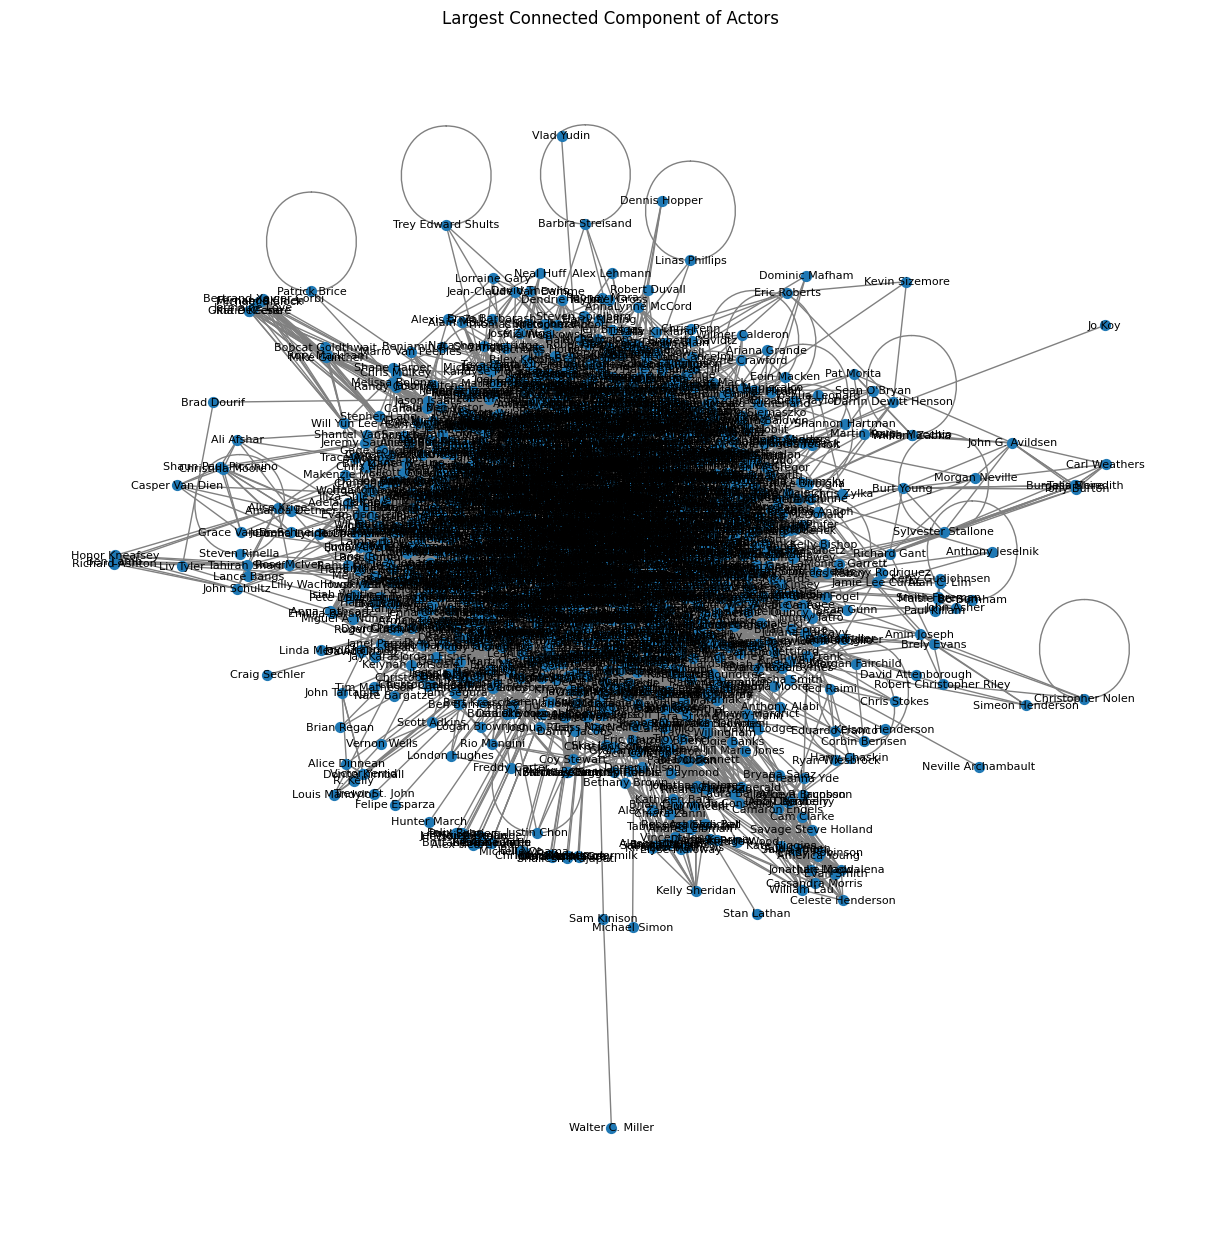

In [118]:
import networkx as nx

df_actor = df.copy()
df_actor = df_actor[df_actor['country'] == 'United States']
df_actor = df_actor[['title', 'director', 'cast']]
df_actor['cast'] = df_actor['cast'].dropna().str.split(', ')
df_actor['cast'] = df_actor.apply(lambda row: row['cast'] + [row['director']] \
                                 if isinstance(row['cast'], list) else row['cast'], axis = 1)
df_actor.dropna(subset = ['cast', 'director']).reset_index(inplace=True, drop=True)

feature_counter = Counter()
for i in df_actor['cast']:
    if isinstance(i, list):
        for person in i:
            feature_counter[person] += 1

feature_counter = {person: count for person, count in feature_counter.items() if count >= 3}
filtered_persons = set(feature_counter.keys())
df_actor['cast'] = df_actor['cast'].apply(lambda row: [element for element in row if element in filtered_persons] if isinstance(row, list) else row)


G = nx.Graph()

for cast_list in df_actor['cast']:
    if isinstance(cast_list, list):
        for i in range(len(cast_list)):
            for j in range(i+1, len(cast_list)):
                G.add_edge(cast_list[i], cast_list[j])

is_connected = nx.is_connected(G)
print("네트워크가 완전히 연결되어 있는가?:", is_connected)


if not is_connected:
    connected_components = list(nx.connected_components(G))
    largest_components_nodes = max(connected_components, key = len)
    largest_components_subgraph = G.subgraph(largest_components_nodes).copy()
    avg_path_length = nx.average_shorted_path_length(largest_components_subgraph)
    print("가장 큰 연결 컴포넌트의 평균 최단 경로 길이:", avg_path_length)

    
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(largest_component_subgraph, seed = 42)
    nx.draw(
        largest_component_subgraph, pos, with_labels = True,
        node_size = 50, font_size = 8 , edge_color = 'gray'
    )
    plt.title("Largest Connected Component of Actors")
    plt.show()

else:

    avg_path_length = nx.average_shortest_path_length(G)
    print("네트워크의 평균 최단 경로 길이:", avg_path_length)
    
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, edge_color='gray')
    plt.title("Social Network of Actors")
    plt.show()



In [124]:
num_people_in_largest_component = len(largest_component_nodes)

print("가장 큰 연결 컴포넌트에 포함된 사람 수:", num_people_in_largest_component)
actor_set = set( actor for row in df_actor['cast'] if isinstance(row, list)  for actor in row)
print(f'전체 배우 수 : {len(actor_set)}')


가장 큰 연결 컴포넌트에 포함된 사람 수: 1870
전체 배우 수 : 1876


미국 영화계에서 3번 이상 영화/TV프로그램에 출연한 디렉터/배우들 1876명 중, 6명을 제외한
1870명은 모두 평균 2.5 다리를 건너면 아는 사이이다. 